Downloading dataset:

In [ ]:
!pip install --upgrade --no-cache-dir gdown

smoke =['1oOi1jrmPN72e9bTqQwQfU34lEV3gnBCH',
        '1WKuxUxGFffGpf8eV4whrKOF8D0F6GNPY',
        '1TeVEMxkgNqTtiHelXEoZ6UL9XkvZXqv2',
        '1UmsjXBY3EYJayfnulVpemiEsFULfHyhs']
for i in smoke:
  !gdown --id $i
!cat smoke100k-L.zip.* > smoke_zip.zip && unzip -q -P ahsz smoke_zip.zip ##&& rm *.zip && rm *.zip.*


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1oOi1jrmPN72e9bTqQwQfU34lEV3gnBCH
To: /content/smoke100k-L.zip.001
100% 2.10G/2.10G [00:17<00:00, 118MB/s] 
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WKuxUxGFffGpf8eV4whrKOF8D0F6GNPY
To: /content/smoke100k-L.zip.002
100% 2.10G/2.10G [00:20<00:00, 102MB/s] 
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Download

In [ ]:
import csv

def read_lines(csv_file):
  with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    lines = list(reader)
  return lines
  
def split(csv_file, train_file, test_file, index):
  
    train_writer = csv.writer(open(train_file, 'w'))
    test_writer = csv.writer(open(test_file, 'w'))
    lines = read_lines(csv_file)
    head = lines[0]
    
    train_rows = lines[:index+1]
    test_rows = lines[index+1:]
    
    train_writer.writerows(train_rows)

    test_writer.writerow(head)
    test_writer.writerows(test_rows)

In [ ]:
csv_file ='/content/smoke100k-L/test/test.csv'
lines = read_lines(csv_file)
print("{} samples in tes file".format(len(lines)-1))

15000 samples in tes file


In [ ]:
%cd /content/smoke100k-L/test

/content/smoke100k-L/test


Working only with test set.
So, spliting test file to 14000/1000 train/test sets.

In [ ]:
!mv test.csv all_samples.csv

split('all_samples.csv', 'train.csv','test.csv',14000)

lines = read_lines('train.csv')
print("{} samples in train file".format(len(lines)-1))
lines = read_lines('test.csv')
print("{} samples in test file".format(len(lines)-1))

14000 samples in train file
1000 samples in test file


In [ ]:
%cd /content

/content


In [ ]:
# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .
!python object_detection/builders/model_builder_test.py



/content/models/research
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.2 MB 6.5 MB/s 
     |████████████████████████████████| 352 kB 63.8 MB/s 
     |████████████████████████████████| 2.0 MB 35.0 MB/s 
     |████████████████████████████████| 25.9 MB 1.1 MB/s 
     |████████████████████████████████| 4.6 MB 47.6 MB/s 
     |████████████████████████████████| 636 kB 60.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.6 MB/s 
     |████████████████████████████████| 511.7 MB 4.2 kB/s 
     |████████████████████████████████| 99 kB 11.1 MB/s 
     |███████████████

In [ ]:
%cd /content

/content


In [ ]:
with open('label_map.pbtxt', 'w') as map:
  map.write(
      """item {
        id: 1
        name: 'smoke'
      }
      """
  )

In [ ]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.1 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
import cv2
import os
path = '/content/smoke100k-L/test/smoke_mask'
masks = os.listdir(path)
for i in masks:

  im_gray = cv2.imread(os.path.join(path,i), cv2.IMREAD_GRAYSCALE)
  im_bw = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY)[1]*(1./255)
  cv2.imwrite(os.path.join(path,i), im_bw)
 


In [ ]:
with open('generate_tfrecord.py', 'w') as tfrec:
  tfrec.write("""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow.compat.v1 as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
FLAGS = flags.FLAGS

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group):
    with tf.gfile.GFile('smoke100k-L/' + group.filename[5:], 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    with tf.gfile.GFile('smoke100k-L/test/smoke_mask/' + group.filename[-11:], 'rb') as fid:
        encoded_mask_png = fid.read()
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'png'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['x'] / width)
        xmaxs.append((row['w'] + row['x']) / width)
        ymins.append(row['y'] / height)
        ymaxs.append((row['h'] + row['y']) / height)
        classes_text.append('smoke'.encode('utf8'))
        classes.append(1)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/mask': dataset_util.bytes_feature(encoded_mask_png),
    }))
    return tf_example


def main(_):
    assert FLAGS.csv_input, '`--csv_input` missing.'
    assert FLAGS.output_path, '`--output_path` missing.'

    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'Smoke_image')
    for group in grouped:
        tf_example = create_tf_example(group)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()
"""
)

In [ ]:
!python generate_tfrecord.py --csv_input=/content/smoke100k-L/test/train.csv --output_path=train.record


Successfully created the TFRecords: /content/train.record


In [ ]:
!python generate_tfrecord.py --csv_input=/content/smoke100k-L/test/test.csv --output_path=test.record


Successfully created the TFRecords: /content/test.record


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz
!tar -xzvf mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz


--2022-05-17 18:32:48--  http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.215.128, 2607:f8b0:400c:c0c::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.215.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484546405 (462M) [application/x-tar]
Saving to: ‘mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz’

mask_rcnn_inception 100%[===================>] 462.10M   182MB/s    in 2.5s    

2022-05-17 18:32:51 (182 MB/s) - ‘mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz’ saved [484546405/484546405]

mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/
mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/checkpoint/
mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/checkpoint/ckpt-0.data-00000-of-00001
mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/checkpoint/c

In [ ]:
with open('/content/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/pipeline.config', 'w') as map:
  map.write("""
# Mask R-CNN with Inception Resnet v2 (no atrous)
# Sync-trained on COCO (with 8 GPUs) with batch size 16 (1024x1024 resolution)
# Initialized from Imagenet classification checkpoint
# TF2-Compatible, *Not* TPU-Compatible
#
# Achieves XXX mAP on COCO

model {
  faster_rcnn {
    number_of_stages: 3
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 224
        width: 224
        # pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_resnet_v2_keras'
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 17
    maxpool_kernel_size: 1
    maxpool_stride: 1
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
        mask_height: 33
        mask_width: 33
        mask_prediction_conv_depth: 0
        mask_prediction_num_conv_layers: 4
        conv_hyperparams {
          op: CONV
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.01
            }
          }
        }
        predict_instance_masks: true
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
    second_stage_mask_prediction_loss_weight: 4.0
    resize_masks: false
  }
}

train_config: {
  batch_size: 1
  num_steps: 200000
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: 0.008
          total_steps: 200000
          warmup_learning_rate: 0.0
          warmup_steps: 5000
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint: "/content/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/checkpoint/ckpt-0"
  fine_tune_checkpoint_type: "detection"
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}

train_input_reader: {
  label_map_path: "/content/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/content/train.record"
  }
  load_instance_masks: true
  mask_type: PNG_MASKS
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  metrics_set: "coco_mask_metrics"
  eval_instance_masks: true
  use_moving_averages: false
  batch_size: 1
  include_metrics_per_category: true
}

eval_input_reader: {
  label_map_path: "/content/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/content/test.record"
  }
  load_instance_masks: true
  mask_type: PNG_MASKS
}
""")

In [ ]:
PIPELINE_CONFIG_PATH='/content/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/pipeline.config'
MODEL_DIR='/content/save'
NUM_TRAIN_STEPS=10000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
!python /content/models/research/object_detection/model_main_tf2.py \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr

2022-05-17 14:23:24.961567: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0517 14:23:24.968110 140410010036096 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0517 14:23:24.972142 140410010036096 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0517 14:23:24.972327 140410010036096 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0517 14:23:25.149492 140410010036096 deprecation.py:343] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experime

In [ ]:
!python /content/models/research/object_detection/exporter_main_v2.py \
--trained_checkpoint_dir=/content/save\
 --pipeline_config_path=/content/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/pipeline.config \
  --output_directory /content/segmodel

2022-05-17 15:11:41.986656: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0517 15:11:42.126434 139866940106624 deprecation.py:615] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of addition

In [ ]:
!zip -r /content/segfile.zip /content/segmodel


  adding: content/segmodel/ (stored 0%)
  adding: content/segmodel/pipeline.config (deflated 70%)
  adding: content/segmodel/saved_model/ (stored 0%)
  adding: content/segmodel/saved_model/assets/ (stored 0%)
  adding: content/segmodel/saved_model/variables/ (stored 0%)
  adding: content/segmodel/saved_model/variables/variables.index (deflated 81%)
  adding: content/segmodel/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/segmodel/saved_model/saved_model.pb (deflated 92%)
  adding: content/segmodel/checkpoint/ (stored 0%)
  adding: content/segmodel/checkpoint/ckpt-0.index (deflated 81%)
  adding: content/segmodel/checkpoint/checkpoint (deflated 42%)
  adding: content/segmodel/checkpoint/ckpt-0.data-00000-of-00001 (deflated 7%)


In [ ]:
from google.colab import files
files.download("/content/segfile.zip")


In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want

PATH_TO_SAVED_MODEL="/content/content/segmodel/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/content/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))



Loading model...Done!


In [ ]:
import itertools
from object_detection.utils import visualization_utils as viz_utils

from object_detection.utils import ops
def run_inference_for_single_image(model, image_np):
    
    #print("Running inference for : ",image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop("num_detections"))

    detections = dict(itertools.islice(detections.items(), num_detections))

    detections["num_detections"] = num_detections

    image_np_with_detections = image_np.copy()

    # Handle models with masks:
    if "detection_masks" in detections:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = ops.reframe_box_masks_to_image_masks(
              detections["detection_masks"][0], detections["detection_boxes"][0],
               image_np.shape[0], image_np.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        detections["detection_masks_reframed"] = detection_masks_reframed.numpy()

    boxes = np.asarray(detections["detection_boxes"][0])
    classes = np.asarray(detections["detection_classes"][0]).astype(np.int64)
    scores = np.asarray(detections["detection_scores"][0])
    mask = np.asarray(detections["detection_masks_reframed"])

    # Visualizing the results
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=mask,
        use_normalized_coordinates=False,
        line_thickness=3)
    
    # Display image with detections and segmented parts
    return Image.fromarray(image_np_with_detections)


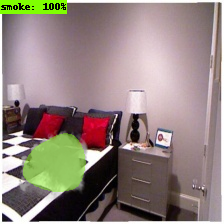

In [ ]:
from PIL import Image
image_np = Image.open('/content/L_00000.png')
image_np = np.asarray(image_np)

display(run_inference_for_single_image(detect_fn, image_np))


For a series of pictures (video..):

In [ ]:
import cv2
from tqdm import tqdm

vid_cap = cv2.VideoCapture('/content/smoke.mp4')
frame_read, img = vid_cap.read()
fps = vid_cap.get(cv2.CAP_PROP_FPS)
w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter('/content/content/segmented_smoke.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w,h))

while(frame_read):
  for i in tqdm(range(frame_count)):
    img = run_inference_for_single_image(detect_fn, img)
    img = np.asarray(img)

    out.write(img)
    frame_read, img = vid_cap.read()

out.release()
vid_cap.release()